In [6]:
%%capture
import sys,os
import numpy as np
from scipy import interpolate,ndimage,stats,signal,integrate,misc,optimize
import aplpy
from astropy.io import ascii,fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as c
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from astropy.table import Table
#import astropy.stats as astrostats
#import astropy.visualization as astroplt
%matplotlib inline

In [7]:
sys.path.insert(1,  os.path.abspath(os.path.expanduser('~/github/arban/')))
import schmidt_funcs as sf
#sys.path.insert(1, os.path.abspath('../sedfitter_cf/OrionProtostars/'))
#import isprotostar as res

mpl.rcParams['font.size'] = 14

In [8]:
import utils as jutil

Previously we used the individual, unmerged catalogs to determine the Schmidt Law.
Generally, we just used the Broekhoven-Fiene et al. catalog.

Now, we combine those catalogs into one `california_yso_catalog.ipac`

```
os.path.isfile(os.path.abspath('./Catalogs/harvey.ipac'))

h = ascii.read(os.path.abspath('./Catalogs/harvey.ipac'))

f_wise = ascii.read(os.path.abspath('./Catalogs/fiene_wise.txt'))

f_irac = ascii.read(os.path.abspath('./Catalogs/fiene_irac.txt'))
```


### Load catalog and maps

In [9]:
%%capture

cat = Table.read('source_table.ascii',format='ascii.fixed_width_two_line')
ra,dec = cat['RA'].__array__(),cat['DEC'].__array__()
coords_orig=SkyCoord(ra,dec,frame='icrs',unit=(u.deg, u.deg))
akmap = fits.getdata(os.path.abspath('./Herschel-California/california_extinction.fits'))#-.1
akwcs = fits.getheader(os.path.abspath('./Herschel-California/california_extinction.fits'))
scale = (np.abs(akwcs['CDELT2']) * 3600. * 450. * u.AU.to(u.pc))**2 # sq. pc per pixel
wcs = WCS(akwcs)
inside_herschel = (cat['DEC'].__array__() < 41) & (cat['RA'].__array__() > 60) #41 -> 40 to cutout top
cat=cat[inside_herschel]
ra,dec = cat['RA'].__array__(),cat['DEC'].__array__() #Extract RA,DEC arrays from catalog


In [10]:
p = cat['Class'].__array__() == 'P'
coord = SkyCoord(ra,dec,frame='icrs',unit = 'degree')

## Error propogation for the YSO surface density, $\Sigma_{\text{YSO}}$

Letting $f\,(A_K) \equiv f\,(\ A_K \in [A_K - \epsilon, A_K + \epsilon)\ ) $

$$\Sigma_{\text{YSO}}(A_K) \equiv \frac{N_{YSO}(A_K)}{A_{YSO}(A_K)} $$

From [Calculating Efficiencies and Their
Uncertainties](http://home.fnal.gov/~paterno/images/effic.pdf). It is from the Binomial distribution (small N, so Poisson is invalid)

$$\sigma_\Sigma = \Sigma \sqrt{\frac{1}{N_{YSO}} - \frac{1}{N_{A_K}} } $$


 ... _Is it really OK to estimate the surface density this way? It is not really a surface density, but really an "effective" or "approximate" surface density._ I don't think it is OK, but doing it anyway. Marco's non-homogenous Poisson Process is better. It takes into account the 2D distribution. 

## Schmidt Law -- Logarithmic Binning

In [57]:
%%capture --no-stdout --no-display
reload(sf)

samp = ext[p]
samperr = ext_err[p]
maps = akmap_im
mapserr = ermap_im
log_alphas = []
log_kappas = []
dexes = np.arange(0.01,1,.05)
log_alphas = []
log_ealphas = []
log_npts = []
shift = sf.llspace(-0.5,0.5,20)
sh = 0
for dex in [0.1]:
    binslog = 10.**(np.log10(sf.llspace(.1 , 8 ,dex=0.1)) + sh*0.1)
    #try:
    logsampler, xlog, ylog, yerrlog, tlog,etlog = sf.fit(binslog, samp, 
                                                             samperr, maps,
                                                             mapserr,log=True,
                                                             scale = scale,
                                                             sampler = None,
                                                             nsteps = 5000,
                                                             burnin=100,threshold=False)
    #    log_alphas.append(tlog[0])
    #    log_ealphas.append(etlog[0])
    #    log_npts.append(np.sum(np.isfinite(1./ylog)))
    #except:
    #    log_alphas.append(np.nan)
    #    log_ealphas.append(np.nan)
    #    log_npts.append(np.nan)

log_alphas = np.asarray(log_alphas)
log_ealphas = np.asarray(log_ealphas)
log_npts = np.asarray(log_npts)

0.05
Hi!. It's hammer time...
Sampler autocorrelation times . . .
[ 29.14576707  25.20228977]
beta = 3.21 (+0.21,-0.21)
kappa = 0.60 (+0.16,-0.12)


beta = 3.21 (+0.21,-0.21)
kappa = 0.60 (+0.16,-0.12)


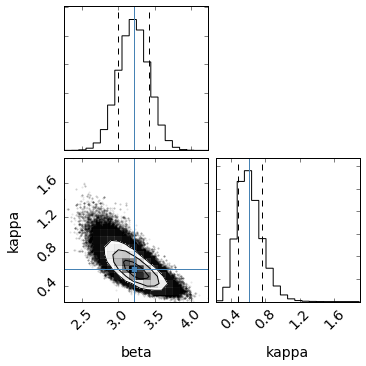

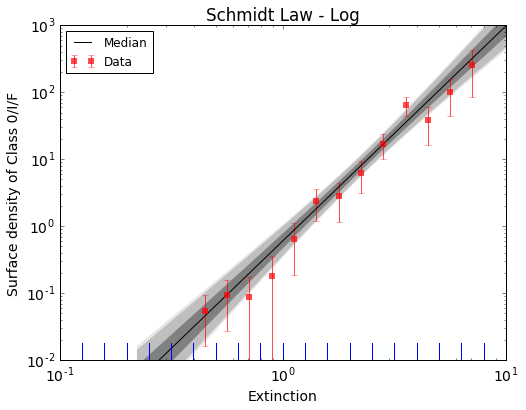

In [58]:
#%%capture --no-display
reload(sf)
ax=sf.schmidt_results_plots(logsampler,sf.schmidt_law,xlog,ylog,yerrlog,burnin=100)
ax.set_ylim(.01,1000)
ax.set_xlim(.1,10)
for b in binslog:
    ax.axvline(b,0,0.05,color='b')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Schmidt Law - Log')
ax.set_xlabel('Extinction')
ax.set_ylabel('Surface density of Class 0/I/F');
#m,b = np.polyfit(np.log(xlog),np.log(ylog),1,w=yerrlog/ylog)
#plt.plot(xlog,np.exp(b)*(xlog**m),'b')
#m,f=sf.lmfit_powerlaw(xlog,ylog,yerrlog,init=(3.03,1.14))
#plt.plot(xlog,np.exp(m(xlog)),'g')

# Marco's Bayesian Method

In [4]:
import emcee
import corner as triangle

In [24]:
x,y=wcs.all_world2pix(coord.ra[p],coord.dec[p],0)

def loglikeli(theta, field, xo, yo):
    '''
    log likelihood from Lombardi et al 2010
    
    I don't multiply by a 'mask' here because
    masked values are stored as NaN values in
    the extinction map. So by nansum-ing the 
    mask is automatically 'applied'
    '''
    sfr = (field > theta[2]).astype(float) * theta[1] * field**theta[0] * scale
    sfr[sfr < 1e-7 ] = 1e-7
    sfrs = sfr[yo.astype(int),xo.astype(int)]
    return (np.nansum(np.log(sfrs)) - np.nansum(sfr))

def lnprior(theta):
    '''
    I separate the prior from the likelihood just
    for my own sake. The normalization is returned
    and added to the likelihood in the next function
    '''
    if 0 < theta[0] < 5 and 0 < theta[1] < 5 and 0 < theta[2] < 5:
        return 3*np.log(5)
    else:
        return -np.inf

def lnprob(theta, field, xo, yo):
    '''
    combindes the likelihood and the prior
    this is the 
    p(D|H)p(H) step. I don't calculate an evidence
    term. I'm not really sure how. And it should be
    a constant, except maybe it is where the correction
    for the threshold should really be. 
    '''
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return loglikeli(theta, field, xo, yo) + lp

def lnprob_minus(theta, field, xo, yo):
    return -lnprob(theta, field, xo, yo)

nwalkers = 100
ndim = 3
pos = (3.1,1.,.8)
pos = [np.array(pos) + np.array([1.,.3,.3]) * 2 * (0.5 - np.random.rand(ndim)) for i in range(nwalkers)]
nsteps  = 100
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = [akmap, x, y],threads=7)


In [ ]:
final_sample = sampler.run_mcmc(pos, nsteps)

In [30]:
p1,p2,p3=sampler.flatchain.T
lp = sampler.flatlnprobability

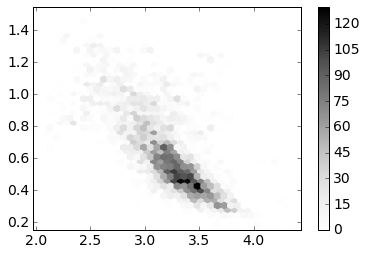

In [43]:
plt.hexbin(p1,p2,gridsize=40,cmap='Greys')
plt.colorbar()

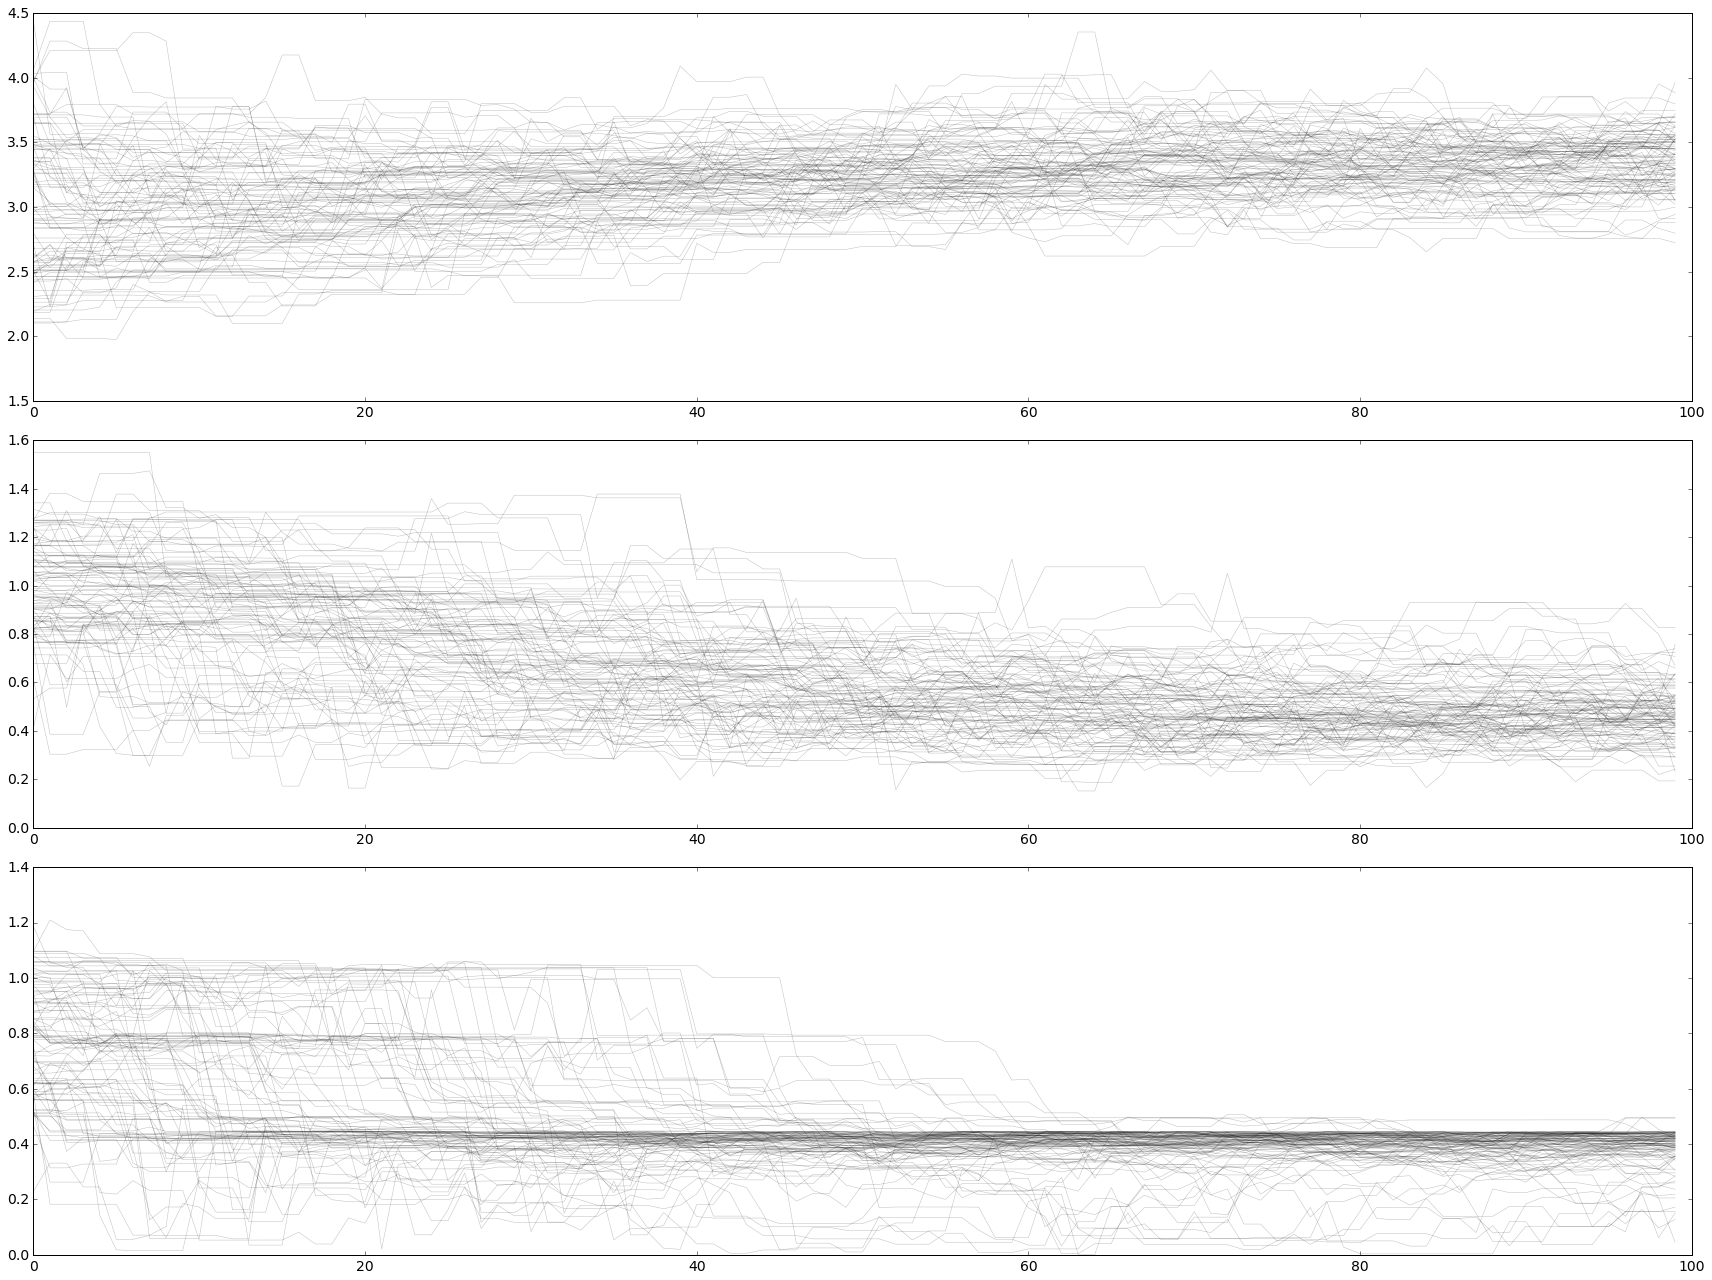

In [33]:
sf.plot_walkers(sampler)

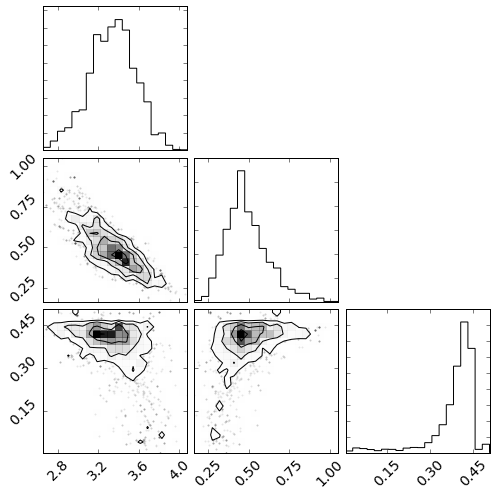

In [36]:
fig=triangle.corner(sampler.chain[:, 70:, :].reshape((-1, sampler.dim)))

In [38]:
np.nanmedian(sampler.chain[:, 70:, :].reshape((-1, sampler.dim)),axis=0)

array([ 3.34455833,  0.470695  ,  0.40877422])

In [48]:
sampler.flatchain[np.where(lp==lp.min())[0],:]

array([[ 4.01227167,  1.20761394,  1.00116532]])

In [ ]:
def lnprob_minus(theta, field, xo, yo):
    return -lnprob(theta, field, xo, yo)
m = optimize.minimize(lnprob_minus,[3.3,0.5,0.4],args=(akmap,x,y),method='Powell')

In [56]:
m

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 282.65272638990467
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 2
  status: 0
 success: True
       x: array([ 3.31595103,  0.48631403,  0.44622851])